# LASSO-BBN

Notes

- dm is response variable

Drop these variables
- Vlr 
- bs15
- TestTrain
- id

Algorithm

- dm ~ bs01lr + bs02lr + ... + bs19lr
- bs01lr ~ bs02lr + ... + bs19lr
- bs07lr ~ bs09lr + .... + bs11lr

What to do about missing values?

- use 1.0 since these are likelihood ratios
- use 0.0 because that might be the right thing to do; but scale data to [0, 1] range before regression
- imputation? 

TODO

- no need to do robust yet
- recursive LASSO
- induce BBN structure
- create parameters
- export graph to show mediations

In [217]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('s3://jeeforce-artifacts/alemi/diabetes/BodySystemTrainTable.csv', low_memory=False)
raw_df.shape

(2063013, 23)

In [218]:
df = raw_df.drop(columns=['id', 'Vlr', 'bs15lr', 'TestTrain']) \
    .rename(columns={
        'bs1lr': 'bs01lr',
        'bs2lr': 'bs02lr',
        'bs3lr': 'bs03lr',
        'bs4lr': 'bs04lr',
        'bs5lr': 'bs05lr',
        'bs6lr': 'bs06lr',
        'bs7lr': 'bs07lr',
        'bs8lr': 'bs08lr',
        'bs9lr': 'bs09lr'
    })
df.shape

(2063013, 19)

In [219]:
df.isna().sum()

dm              0
bs01lr    1728725
bs02lr    1584907
bs03lr     781920
bs04lr    1798421
bs05lr     988523
bs06lr     899715
bs07lr     795886
bs08lr    1375571
bs09lr    1250320
bs10lr    1422029
bs11lr    2060940
bs12lr    1558015
bs13lr     854697
bs14lr    2013741
bs16lr     765461
bs17lr    1653390
bs18lr    1901535
bs19lr     118312
dtype: int64

In [220]:
df.iloc[0]

dm        1.000000
bs01lr         NaN
bs02lr         NaN
bs03lr    1.645058
bs04lr         NaN
bs05lr    1.195137
bs06lr         NaN
bs07lr    1.213059
bs08lr         NaN
bs09lr    1.960372
bs10lr         NaN
bs11lr         NaN
bs12lr         NaN
bs13lr         NaN
bs14lr         NaN
bs16lr    1.520102
bs17lr         NaN
bs18lr         NaN
bs19lr         NaN
Name: 0, dtype: float64

In [221]:
order_df = pd.read_csv('s3://jeeforce-artifacts/alemi/diabetes/ordering.csv') \
    .query('code != "rare_disease"')
order_df

,name,code,coefficient
0,Diseases_of_the_circulatory_system,bs07lr,0.175061
1,"Endocrine,nutritional_and_metabolic diseases_a...",bs03lr,0.138932
2,Mental_disorders,bs05lr,0.107442
3,Diseases_of_the_musculoskeletal_system_and_con...,bs13lr,0.022813
4,Diseases_of_the_digestive_system,bs09lr,0.021342
5,Diseases_of_the_respiratory_system,bs08lr,0.016024
6,Infectious_and_parasitic_diseases,bs01lr,0.014166
7,Diseases_of_the_genitourinary_system,bs10lr,0.006209
8,V_codes,bs19lr,-0.010618
9,Neoplasms,bs02lr,-0.013564


In [222]:
def get_order(code):
    r = order_df[order_df['code']==code].iloc[0]
    c = r['coefficient']
    codes = list(order_df[order_df['coefficient'] > c]['code'])
    return codes

order_map = {code: get_order(code) for code in order_df['code']}
order_map = {**order_map, **{'dm': list(order_df['code'])}}

In [223]:
order_map

{'bs07lr': [],
 'bs03lr': ['bs07lr'],
 'bs05lr': ['bs07lr', 'bs03lr'],
 'bs13lr': ['bs07lr', 'bs03lr', 'bs05lr'],
 'bs09lr': ['bs07lr', 'bs03lr', 'bs05lr', 'bs13lr'],
 'bs08lr': ['bs07lr', 'bs03lr', 'bs05lr', 'bs13lr', 'bs09lr'],
 'bs01lr': ['bs07lr', 'bs03lr', 'bs05lr', 'bs13lr', 'bs09lr', 'bs08lr'],
 'bs10lr': ['bs07lr',
  'bs03lr',
  'bs05lr',
  'bs13lr',
  'bs09lr',
  'bs08lr',
  'bs01lr'],
 'bs19lr': ['bs07lr',
  'bs03lr',
  'bs05lr',
  'bs13lr',
  'bs09lr',
  'bs08lr',
  'bs01lr',
  'bs10lr'],
 'bs02lr': ['bs07lr',
  'bs03lr',
  'bs05lr',
  'bs13lr',
  'bs09lr',
  'bs08lr',
  'bs01lr',
  'bs10lr',
  'bs19lr'],
 'bs06lr': ['bs07lr',
  'bs03lr',
  'bs05lr',
  'bs13lr',
  'bs09lr',
  'bs08lr',
  'bs01lr',
  'bs10lr',
  'bs19lr',
  'bs02lr'],
 'bs04lr': ['bs07lr',
  'bs03lr',
  'bs05lr',
  'bs13lr',
  'bs09lr',
  'bs08lr',
  'bs01lr',
  'bs10lr',
  'bs19lr',
  'bs02lr',
  'bs06lr'],
 'bs16lr': ['bs07lr',
  'bs03lr',
  'bs05lr',
  'bs13lr',
  'bs09lr',
  'bs08lr',
  'bs01lr',
  'bs10l

In [538]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.special import expit
from sklearn.metrics import r2_score
import time

alphas = {
    'bs01lr': 0.001,
    'bs02lr': 0.005,
    'bs03lr': 0.000001,
    'bs04lr': 0.002,
    'bs05lr': 0.002,
    'bs06lr': 0.005,
    'bs07lr': 0.005,
    'bs08lr': 0.003,
    'bs09lr': 0.003,
    'bs10lr': 0.003,
    'bs11lr': 0.0119,
    'bs12lr': 0.0019,
    'bs13lr': 0.0019,
    'bs14lr': 0.22,
    'bs16lr': 0.05,
    'bs17lr': 0.005,
    'bs18lr': 0.005,
    'bs19lr': 0.005
}

def mcfadden(estimator, X, y, method='normal'):
    def full_log_likelihood():
        score = estimator.predict_proba(X)[:,1]
        return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

    def null_log_likelihood():
        model = estimator.named_steps['regressor']
        score = np.array([model.intercept_[0] for _ in range(len(y))])
        return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

    def mcfadden_rsquare():
        return 1.0 - (full_log_likelihood() / null_log_likelihood())
    
    def mcfadden_adjusted_rsquare():
        k = float(X.shape[1])
        return 1.0 - ((full_log_likelihood() - k) / null_log_likelihood())
    
    if method == 'normal':
        return mcfadden_rsquare()
    else:
        return mcfadden_adjusted_rsquare()

def log_time(y_field, t0, t1):
    diff = t1 - t0
    diff = diff / 60
    print(f'\t{y_field} @ {diff:.1} minutes')
    
def get_coef(estimator, X, y_field):
    model = estimator.named_steps['regressor']
    coef = model.coef_[0] if y_field == 'dm' else model.coef_
    
    return pd.Series(coef, index=X.columns) \
        .to_frame(name='coefficient') \
        .reset_index() \
        .rename(columns={'index': 'field'}) \
        .assign(abs_coefficient=lambda d: np.abs(d['coefficient'])) \
        .sort_values(['abs_coefficient'], ascending=False) \
        .reset_index(drop=True)

def get_Xy(df, y_field):
    temp_df = df[df[y_field].notna()]
    X = temp_df[[c for c in df.columns if c in order_map[y_field]]]
    y = temp_df[y_field]
    
    return X, y

def get_regressor(y_field, C, tol):
    if y_field == 'dm':
        model = LogisticRegression(
            random_state=37,
            penalty='l1', 
            C=C, 
            max_iter=5_000, 
            tol=tol, 
            n_jobs=-1, 
            solver='saga')
    else:
        alpha = alphas[y_field]
        model = Lasso(alpha=alpha, max_iter=5_000, random_state=37)
        
    return model

def get_estimator(y_field, C, tol):
    estimator = Pipeline([
        ('imputer', IterativeImputer(max_iter=100, random_state=37)),
        ('scaler', MinMaxScaler()),
        ('regressor', get_regressor(y_field, C, tol))
    ])
    
    return estimator

def get_r2_score(estimator, X, y, y_field):
    if y_field == 'dm':
        r_sq = mcfadden(estimator, X, y)
    else:
        r_sq = r2_score(estimator.predict(X), y)
    
    return r_sq

def do_learn(df, y_field, C=0.0002, tol=0.01):
    print(f'{y_field}')
    
    X, y = get_Xy(df, y_field)        
    print(f'\t{X.shape}, {y.shape}')
    
    if X.shape[0] == 0 or X.shape[1] == 0:
        return None
    
    estimator = get_estimator(y_field, C, tol)
    
    t0 = time.time()
    estimator.fit(X, y)
    t1 = time.time()
    log_time(y_field, t0, t1)
    
    coef_df = get_coef(estimator, X, y_field)
    print(f'\tnon-zero coefficients: {(coef_df[coef_df["abs_coefficient"] > 0.01]).shape[0]}')
    
    r_sq = get_r2_score(estimator, X, y, y_field)
    print(f'\tr_sq={r_sq:.5f}')
        
    return coef_df

In [539]:
# do_learn(df, 'bs01lr')

In [541]:
# do_learn(df, 'dm')

In [542]:
results = {y_field: do_learn(df, y_field) for y_field in sorted(list(order_map.keys()))}

bs01lr
	(334288, 6), (334288,)
	bs01lr @ 0.01 minutes
	non-zero coefficients: 3
	r_sq=-85.87708
bs02lr
	(478106, 9), (478106,)
	bs02lr @ 0.1 minutes
	non-zero coefficients: 2
	r_sq=-102.35548
bs03lr
	(1281093, 1), (1281093,)
	bs03lr @ 0.0006 minutes
	non-zero coefficients: 1
	r_sq=-19882.71731
bs04lr
	(264592, 11), (264592,)
	bs04lr @ 0.2 minutes
	non-zero coefficients: 3
	r_sq=-1279.90819
bs05lr
	(1074490, 2), (1074490,)
	bs05lr @ 0.005 minutes
	non-zero coefficients: 1
	r_sq=-640.05401
bs06lr
	(1163298, 10), (1163298,)
	bs06lr @ 0.4 minutes
	non-zero coefficients: 1
	r_sq=-22609.79748
bs07lr
	(1267127, 0), (1267127,)
bs08lr
	(687442, 5), (687442,)
	bs08lr @ 0.02 minutes
	non-zero coefficients: 2
	r_sq=-798.67283
bs09lr
	(812693, 4), (812693,)
	bs09lr @ 0.02 minutes
	non-zero coefficients: 2
	r_sq=-234.60197
bs10lr
	(640984, 7), (640984,)
	bs10lr @ 0.08 minutes
	non-zero coefficients: 3
	r_sq=-1167.93940
bs11lr
	(2073, 15), (2073,)
	bs11lr @ 0.004 minutes
	non-zero coefficients: 3
	r_

In [570]:
def get_parents(key, zero_threshold=0.00):
    try:
        temp_df = results[key]
        temp_df = temp_df[temp_df['abs_coefficient'] > zero_threshold]
        return list(temp_df['field'])
    except:
        return []
    
parents = {ch: sorted(get_parents(ch)) for ch in results}
parents

{'bs01lr': ['bs05lr', 'bs09lr', 'bs13lr'],
 'bs02lr': ['bs03lr', 'bs09lr'],
 'bs03lr': ['bs07lr'],
 'bs04lr': ['bs02lr', 'bs06lr', 'bs09lr'],
 'bs05lr': ['bs03lr'],
 'bs06lr': ['bs13lr'],
 'bs07lr': [],
 'bs08lr': ['bs05lr', 'bs13lr'],
 'bs09lr': ['bs05lr', 'bs13lr'],
 'bs10lr': ['bs01lr', 'bs08lr', 'bs09lr'],
 'bs11lr': ['bs01lr', 'bs03lr', 'bs10lr', 'bs13lr'],
 'bs12lr': ['bs03lr', 'bs06lr', 'bs13lr'],
 'bs13lr': ['bs03lr', 'bs05lr'],
 'bs14lr': ['bs05lr', 'bs13lr'],
 'bs16lr': ['bs01lr', 'bs13lr'],
 'bs17lr': ['bs09lr'],
 'bs18lr': ['bs17lr'],
 'bs19lr': ['bs03lr', 'bs05lr', 'bs09lr'],
 'dm': ['bs01lr', 'bs05lr', 'bs06lr', 'bs09lr', 'bs12lr', 'bs13lr']}

In [571]:
import networkx as nx

g = nx.DiGraph()

for ch, pas in parents.items():
    for pa in pas:
        g.add_edge(pa, ch)

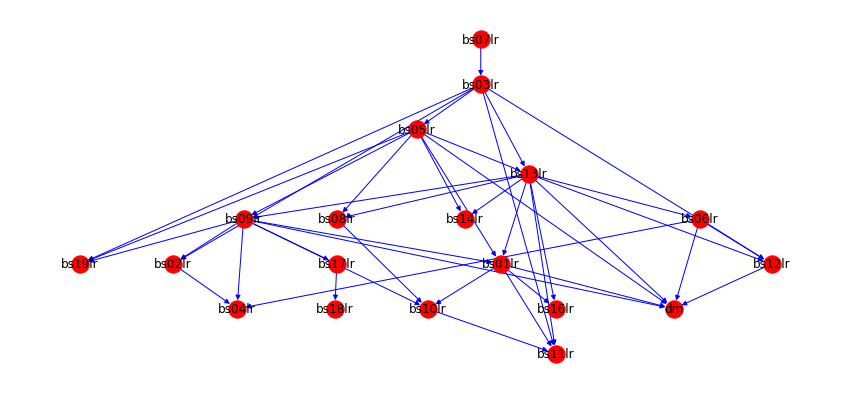

In [572]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

pos = graphviz_layout(g, prog='dot')

fig, ax = plt.subplots(figsize=(15, 7))
nx.draw(**{
        'G': g,
        'ax': ax,
        'pos': pos,
        'with_labels': True,
        'node_color': 'r',
        'edge_color': 'b'
    })

In [593]:
D = df[[c for c in df.columns if c != 'dm']] \
    .applymap(lambda v: np.nan if pd.isna(v) else 1 if v >= 2.0 else 0) \
    .assign(dm=df['dm'])

df.shape, D.shape

((2063013, 19), (2063013, 19))

In [610]:
import itertools

def get_params(y_field):
    def get_param_estimator():
        q = D[y_field].notna()

        X = D[q][parents[y_field]]
        y = D[q][y_field]

        model = LogisticRegression(
                random_state=37,
                penalty='l2', 
                max_iter=5_000, 
                n_jobs=-1, 
                tol=0.01,
                solver='saga')

        estimator = Pipeline([
            ('imputer', SimpleImputer()),
            ('regressor', model)
        ])

        estimator.fit(X, y)

        return estimator

    def get_pa_value_combos():
        values = [(0, 1) for _ in range(len(parents[y_field]))]
        values = list(itertools.product(*values))
        values = pd.DataFrame(values, columns=parents[y_field])

        return values
    
    def get_serializable_cpt(cpt):
        if len(cpt.shape) == 1:
            return [float(v) for v in cpt]
        else:
            return [[float(v) for v in r] for r in cpt]
    
    if len(parents[y_field]) == 0:
        q = D[y_field].notna()
        y = D[q][y_field]
        y = y.value_counts().sort_index()
        y = y / y.sum()
        
        cpt = np.array(y)
    else:
        e = get_param_estimator()
        cpt = e.predict_proba(get_pa_value_combos())
    
    return {
        'cpt': get_serializable_cpt(cpt),
        'parents': parents[y_field]
    }

In [611]:
params = {c: get_params(c) for c in df.columns}
params

{'dm': {'cpt': [[0.8682813760067857, 0.13171862399321435],
   [0.7840104742082059, 0.21598952579179406],
   [0.8078182123059288, 0.1921817876940712],
   [0.698305119037417, 0.30169488096258296],
   [0.7915393308372818, 0.2084606691627182],
   [0.6764650923594449, 0.32353490764055515],
   [0.707707669656831, 0.292292330343169],
   [0.5714136951869733, 0.42858630481302673],
   [0.7714630376935141, 0.2285369623064859],
   [0.6502038678779559, 0.3497961321220441],
   [0.6827932421779574, 0.31720675782204255],
   [0.5423937083961986, 0.4576062916038014],
   [0.660376431261425, 0.339623568738575],
   [0.5170725648726961, 0.4829274351273039],
   [0.553548763200901, 0.44645123679909904],
   [0.40573245017553505, 0.594267549824465],
   [0.7671866111050093, 0.2328133888949907],
   [0.6447034139848604, 0.35529658601513964],
   [0.6775511090357473, 0.3224488909642527],
   [0.5364067017838166, 0.4635932982161834],
   [0.6549510505385385, 0.3450489494614615],
   [0.5110529140108926, 0.48894708598910

In [617]:
n2c = {
    'infec_parasitic': 'bs01lr',
    'neoplasms': 'bs02lr',
    'obesity': 'bs03lr',
    'blood': 'bs04lr',
    'mental': 'bs05lr',
    'nervous_sys': 'bs06lr',
    'circ_sys': 'bs07lr',
    'resp_sys': 'bs08lr',
    'dige_sys': 'bs09lr',
    'gen_uri_sys': 'bs10lr',
    'pregnancy': 'bs11lr',
    'skin': 'bs12lr',
    'muscle_sys': 'bs13lr',
    'congenital': 'bs14lr',
    'ill_defcond': 'bs16lr',
    'inj_poi': 'bs17lr',
    'ecodes': 'bs18lr',
    'vcodes': 'bs19lr',
    'rare_disease': 'rare_disease',
    'dm': 'dm'
}
c2n = {v: k for k, v in n2c.items()}

In [619]:
import json

json.dumps({c2n[k]: {'cpt': v['cpt'], 'parents': [c2n[p] for p in v['parents']]} for k, v in params.items()})

'{"dm": {"cpt": [[0.8682813760067857, 0.13171862399321435], [0.7840104742082059, 0.21598952579179406], [0.8078182123059288, 0.1921817876940712], [0.698305119037417, 0.30169488096258296], [0.7915393308372818, 0.2084606691627182], [0.6764650923594449, 0.32353490764055515], [0.707707669656831, 0.292292330343169], [0.5714136951869733, 0.42858630481302673], [0.7714630376935141, 0.2285369623064859], [0.6502038678779559, 0.3497961321220441], [0.6827932421779574, 0.31720675782204255], [0.5423937083961986, 0.4576062916038014], [0.660376431261425, 0.339623568738575], [0.5170725648726961, 0.4829274351273039], [0.553548763200901, 0.44645123679909904], [0.40573245017553505, 0.594267549824465], [0.7671866111050093, 0.2328133888949907], [0.6447034139848604, 0.35529658601513964], [0.6775511090357473, 0.3224488909642527], [0.5364067017838166, 0.4635932982161834], [0.6549510505385385, 0.3450489494614615], [0.5110529140108926, 0.4889470859891074], [0.5475859679517182, 0.4524140320482818], [0.399935553157